In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import re

from scipy.io import readsav

from astropy.time import Time
from astropy.time import TimeDelta

from sunpy import timeseries as ts
from sunpy.net import attrs as a
from sunpy.net import Fido
from sunpy.time import parse_time, find_time

import pandas as pd

import goesxrs_temp as gtem #from Ian's functions

import Onsets_temp as onsets

# Just setup plot fonts
plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular", 'axes.linewidth' : 2})

# Graphs for Presentation
Going to use the M7.3 Flare from the paper as main example

In [5]:
fl_path = r"D:\MastersProj\Data\goes15\2010\11\sci_gxrs-l2-irrad_g15_d20101105_v0-0-0.nc"

## GOES Lightcurve

In [6]:
#Load flare into time series
g15 = ts.TimeSeries(fl_path, concatenate=True)

# Extract out the time index and data channels for the full day
g_tims = g15.index
g_short = g15.quantity("xrsa").value 
g_long = g15.quantity("xrsb").value
g_short_flag = g15.quantity("xrsa_quality").value 
g_long_flag = g15.quantity("xrsb_quality").value 

In [7]:
# Create a Boolean mask where onset flag is equal to 1
mask_long = g_long_flag != 0
mask_short = g_short_flag != 0

# Set the corresponding values in g_short and g_long to NaN
g_short[mask_short] = np.nan
g_long[mask_long] = np.nan

In [8]:
# Find flare in our processed data
fl_infos = pd.read_csv("Full_Run_v7.csv")
fl_info = fl_infos.iloc[798]

In [13]:
more_infos = pd.read_csv("GOES15_HEK_Data.csv")
more_infos = more_infos[more_infos['event_starttime'].str.contains("2010-11-05")]

In [10]:
mask_short_mask = g_short <= 0 
g_short[mask_short_mask] = np.nan 

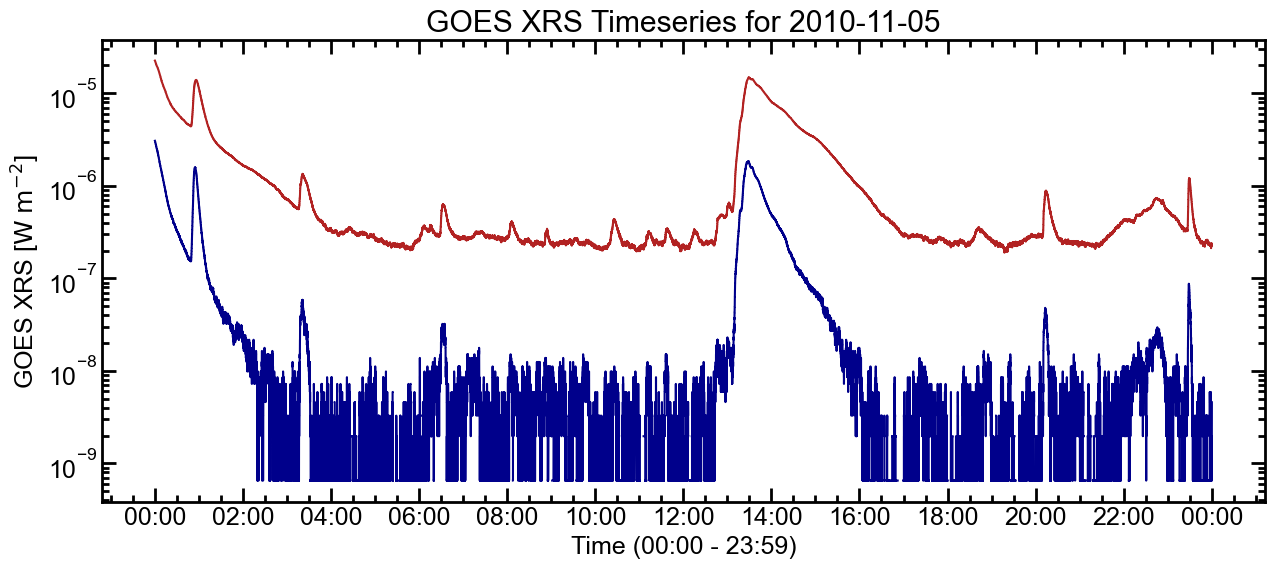

In [11]:
fig,ax = plt.subplots(figsize=(15, 6))
plt.title("GOES XRS Timeseries for 2010-11-05")
plt.plot(g_tims, g_long, drawstyle='steps-post', color = 'firebrick',  label = r"$1.0-8.0\;\AA$")
plt.plot(g_tims, g_short, drawstyle='steps-post', color = 'darkblue', label = r"$0.5-4.0\;\AA$")

for index, row in more_infos.iterrows():
    if row['fl_goescls'].__contains__("M"):
        ax.axvline(parse_time(fl_info["event_peaktime"]).datetime,ls='-.', color = 'blue',label = "M1.0 Flare")
        ax.axvspan(parse_time(fl_info["event_starttime"]).datetime, parse_time(fl_info["event_endtime"]).datetime,color='black',alpha=0.2)
    else:
        if row['Origin'] == "SSW":
            ax.axvline(parse_time(row["event_peaktime"]).datetime,ls='-.',label = row["fl_goescls"])
            ax.axvspan(parse_time(row["event_starttime"]).datetime, parse_time(row["event_endtime"]).datetime,color='green',alpha=0.2)
        if row['Origin'] == "GOES":
            ax.axvline(parse_time(row["event_peaktime"]).datetime,ls='-.',label = row["fl_goescls"])
            ax.axvspan(parse_time(row["event_starttime"]).datetime, parse_time(row["event_endtime"]).datetime,color='orange',alpha=0.2)


# print(type(parse_time(fl["event_peaktime"]).datetime))

ax.set_ylabel("GOES XRS [$\mathrm{W\;m^{-2}}$] ")
ax.set_xlabel("Time (00:00 - 23:59)")
ax.set_yscale("log")

myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.HourLocator(interval=2)
minorx= matplotlib.dates.MinuteLocator(interval=30)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
plt.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
plt.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
plt.tick_params(which='major', size=10, width=2, direction='in', right='on')
plt.tick_params(which='minor', size=5, width=2, direction='in', right='on')

#plt.legend(fancybox = True, fontsize = 11, framealpha = 1, edgecolor = 'black')
plt.minorticks_on()
plt.savefig("Presentation_Graphs/GOES_Day.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

In [12]:
gtstart=Time(fl_info["event_starttime"],scale='utc')-TimeDelta(19.5*60,format='sec')
gtend=Time(fl_info["event_endtime"],scale='utc')+TimeDelta(19.5*60,format='sec')
trunc_range=a.Time(gtstart.iso,gtend.iso)
trunc_g15=g15.truncate(trunc_range.start.iso,trunc_range.end.iso)

# Extract out the time index and data channels
tg_tims = trunc_g15.index
tg_short = trunc_g15.quantity("xrsa").value
tg_long = trunc_g15.quantity("xrsb").value

# Calculating the peak flux (for new classification)
print(f"The peak long channel XRS flux is: {np.max(tg_long):.2e} Wm^-2")

# Smoothing short channel flux to 10s bins.
df_short = pd.Series(tg_short, index = pd.DatetimeIndex(tg_tims))
df_short = df_short.dropna()
df_short = df_short.drop(df_short[df_short <= 10**(-11)].index) #Removes NaN's and dropouts (under 10e-9)
# df_short_ds = df_short.resample('10S').mean() 

df_long = pd.Series(tg_long, index = pd.DatetimeIndex(tg_tims))
df_long = df_long.dropna()
df_long = df_long.drop(df_short[df_short <= 10**(-11)].index) #Removes NaN's and dropouts (under 10e-9)
#df_long_ds = df_short.resample('10S').mean() 

# Plotting
fig,ax = plt.subplots(figsize=(15, 6))
plt.title("M1.0 Flare on 5-Nov-2010")
plt.plot(df_long.index, df_long, color = 'firebrick',  label = r"$1.0-8.0\;\AA$")
plt.plot(df_short.index, df_short, color = 'darkblue', label = r"$0.5-4.0\;\AA$")

ax.axvline(parse_time(fl_info["event_peaktime"]).datetime,ls='-.', color = 'purple',label = "NOAA Peak Time: 13:29")
# ax.axvspan(parse_time(fl_info["event_starttime"]).datetime, parse_time(fl_info["event_endtime"]).datetime,color='black',alpha=0.2)
ax.axvline(parse_time(fl_info["event_starttime"]).datetime,ls='-.', color = 'green', label = 'NOAA Start Time: 13:05')
ax.axvline(parse_time(fl_info["event_endtime"]).datetime,ls='-.', color = 'green',label = 'NOAA End Time: 14:10')
ax.set_ylabel("GOES XRS Flux [$\mathrm{W\;m^{-2}}$]")
ax.set_xlabel("Start Time (12:45:00)")
ax.set_yscale("log")

myFmt = matplotlib.dates.DateFormatter('%H:%M')
# majorx= matplotlib.dates.HourLocator(interval=0.5)
majorx= matplotlib.dates.MinuteLocator(interval=15)
minorx= matplotlib.dates.MinuteLocator(interval=3)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')

class_fluxes = {'A':1e-8,'B': 1e-7, 'C': 1e-6, 'M': 1e-5, 'X': 1e-4}

# Set the tick locations and labels on the secondary y-axis
goes_ax = ax.secondary_yaxis('right')
goes_ax.set_yticks([class_fluxes['A'],class_fluxes['B'], class_fluxes['C'], class_fluxes['M'], class_fluxes['X']])
goes_ax.set_yticklabels(['A','B', 'C', 'M', 'X'], fontsize=18)
goes_ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
goes_ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
goes_ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
goes_ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
goes_ax.set_ylabel('GOES Class', fontsize=18)


ax.legend(fancybox = True, loc = "upper left", fontsize = 11, framealpha = 1, edgecolor = 'black')
plt.savefig("Presentation_Graphs/GOES.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

ValueError: zero-size array to reduction operation maximum which has no identity

## Temperature Responses

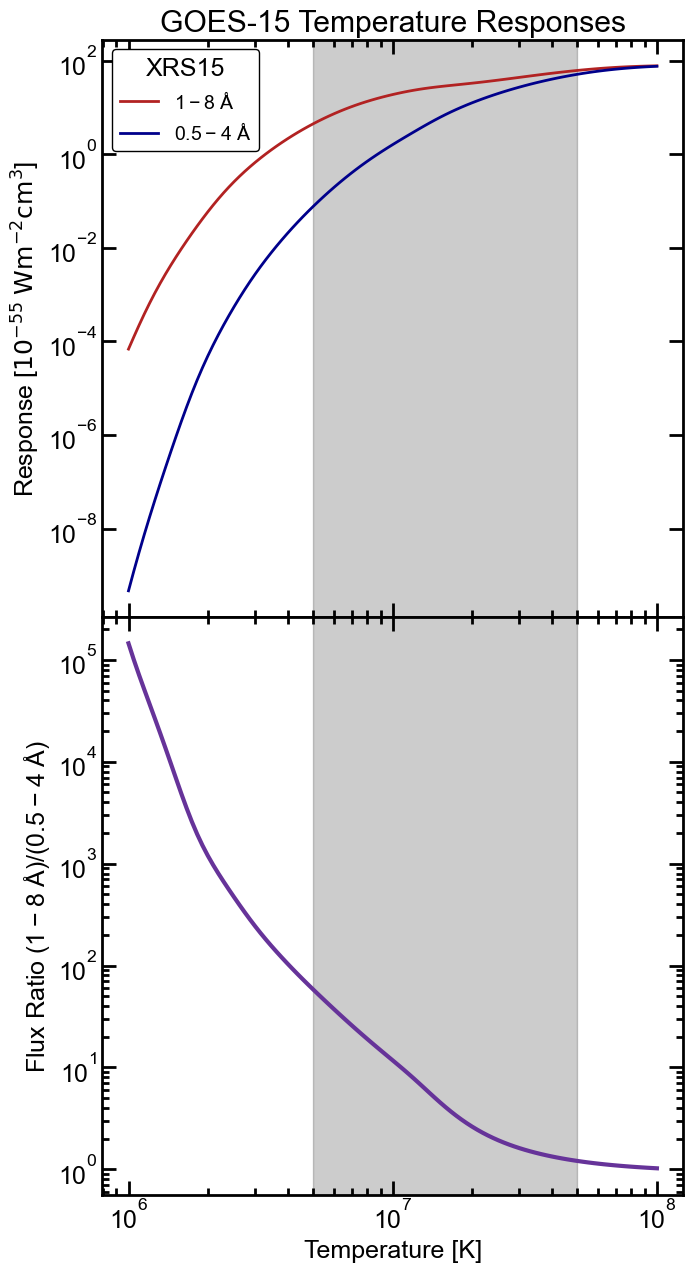

In [ ]:
sat = 15
resps_old, resptmk_old = gtem.get_resps(sat=sat,old_ver=True)
resps, resptmk = gtem.get_resps(sat=sat)

# Plot them to see what they look like:
fig= plt.figure(figsize=(7.5,15))
plt.subplots_adjust(wspace = 0, hspace = 0)

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title("GOES-15 Temperature Responses")
ax1.plot(1e6*resptmk,resps[:,0],marker=None,color='firebrick',lw=2,label='$1-8\;\AA$')
ax1.plot(1e6*resptmk,resps[:,1],marker=None,color='darkblue',lw=2,label='$0.5-4\;\AA$')
ax1.axvspan(5e6, 5e7, color = 'black', alpha = 0.2)
ax1.set_ylabel("Response [$\mathrm{10^{-55}\;Wm^{-2}cm^{3}}$]")
ax1.set_xlabel("Temperature [K]")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax1.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax1.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax1.legend(fancybox = True,title='XRS{:.0f}'.format(sat),loc = "upper left", fontsize = 14, framealpha = 1, edgecolor = 'black')

#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(1e6*resptmk,resps[:,0]/resps[:,1],marker=None,color='rebeccapurple',lw=3)
ax2.axvspan(5e6, 5e7, color = 'black', alpha = 0.2)
ax2.set_ylabel("Flux Ratio $(1-8\;\AA)$/$(0.5-4\;\AA)$")
ax2.set_xlabel("Temperature [K]")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax2.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax2.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax2.tick_params(which='minor', size=5, width=2, direction='in', right='on')

plt.savefig("Presentation_Graphs/TResponses.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

## Looking at T, EM


Mean T during onset: 9.88 MK
Mean EM during onset: 3.46e+48 cm^-3


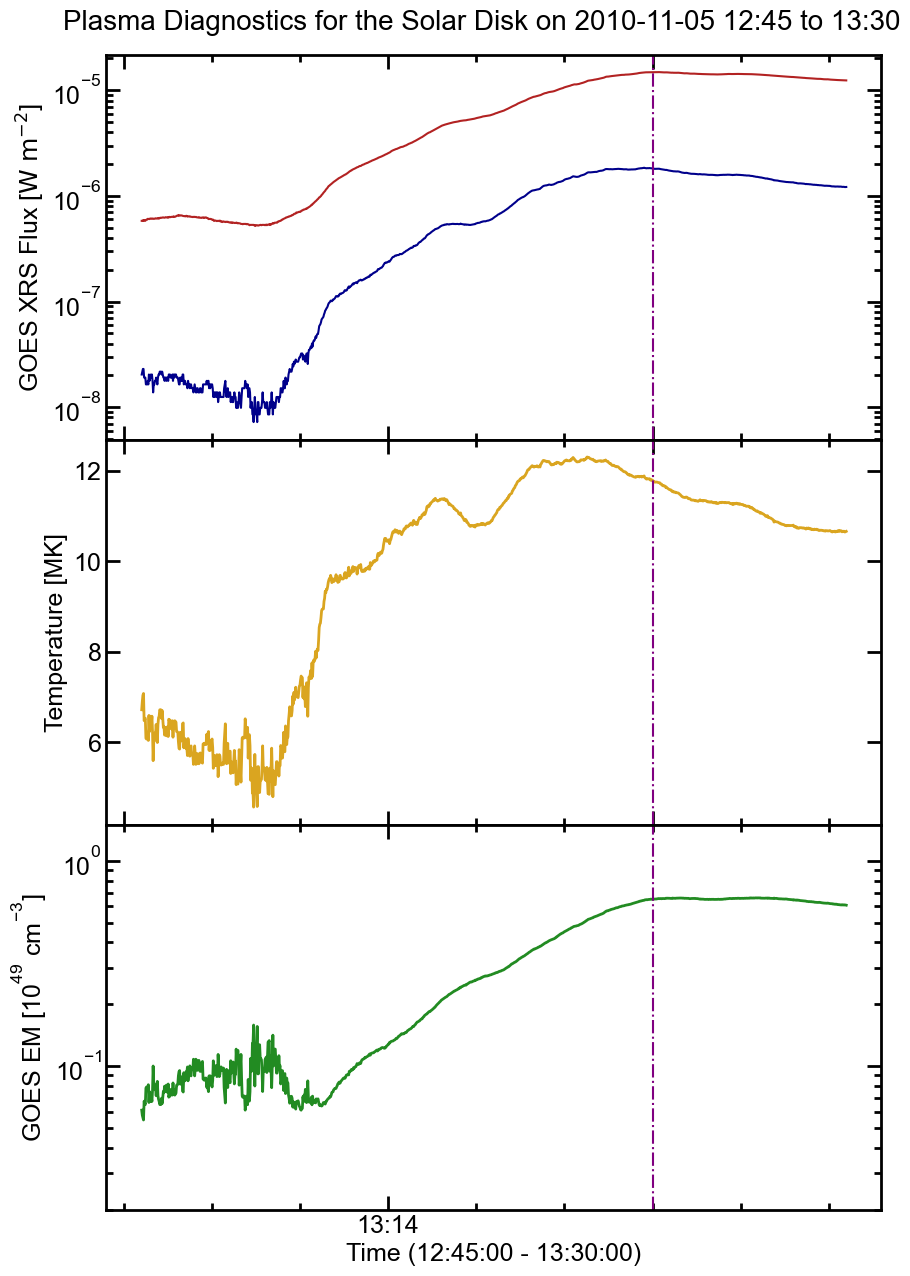

In [ ]:
# Fetching Temperature and Emission Measures
tmk, em = gtem.get_tem(df_long.values, df_short.values)

#calculating mean T, EM for backsubbed new data.
tmk_mnho=np.mean(tmk)
em_mnho=np.mean(em)

print("")
print('Mean T during onset: {0:.2f} MK'.format(tmk_mnho))
print('Mean EM during onset: {0:.2e} cm^-3'.format(em_mnho))

# Plotting
fig= plt.figure(figsize=(10,15))
plt.suptitle("Plasma Diagnostics for the Solar Disk on 2010-11-05 12:45 to 13:30", y = 0.91, fontsize=20)
plt.subplots_adjust(wspace = 0, hspace = 0)
#plt.title("M1.0 Flare on 5-Nov-2010")
ax = fig.add_subplot(3,1,1)
ax.plot(df_long.index, df_long, color = 'firebrick',  label = r"$1.0-8.0\;\AA$")
ax.plot(df_short.index, df_short, color = 'darkblue', label = r"$0.5-4.0\;\AA$")
ax.axvline(parse_time(fl_info["event_peaktime"]).datetime,ls='-.', color = 'purple',label = "NOAA Peak Time: 13:29")
# # ax.axvspan(parse_time(fl_info["event_starttime"]).datetime, parse_time(fl_info["event_endtime"]).datetime,color='black',alpha=0.2)
# ax.axvline(parse_time(fl_info["event_starttime"]).datetime,ls='-.', color = 'green', label = 'NOAA Start Time: 13:05')
# ax.axvline(parse_time(fl_info["event_endtime"]).datetime,ls='-.', color = 'green',label = 'NOAA End Time: 14:10')
ax.set_ylabel("GOES XRS Flux [$\mathrm{W\;m^{-2}}$]")
ax.set_yscale("log")
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=15)
minorx= matplotlib.dates.MinuteLocator(interval=5)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax.xaxis.set_ticklabels([])

ax1 = fig.add_subplot(3, 1, 2)
#ax1.set_title("GOES-15 Temperature Responses")
ax1.plot(df_long.index,tmk,marker=None,color='goldenrod',lw=2,label="Temperature")
ax1.axvline(parse_time(fl_info["event_peaktime"]).datetime,ls='-.', color = 'purple',label = "NOAA Peak Time: 13:29")
ax1.set_ylabel("Temperature [MK]")
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=15)
minorx= matplotlib.dates.MinuteLocator(interval=5)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
ax1.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax1.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax1.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax1.xaxis.set_ticklabels([])

#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax2 = fig.add_subplot(3, 1, 3)
ax2.plot(df_long.index,em*1e-49,marker=None,color='forestgreen',lw=2, label = "Emission Measure")
ax2.axvline(parse_time(fl_info["event_peaktime"]).datetime,ls='-.', color = 'purple',label = "NOAA Peak Time: 13:29")
ax2.set_xlabel("Time (12:45:00 - 13:30:00)")
ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_yscale("log")
ax2.set_ylim([2e-2, 1.5e0])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=30)
minorx= matplotlib.dates.MinuteLocator(interval=5)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
ax2.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax2.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax2.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax2.tick_params(which='minor', size=5, width=2, direction='in', right='on')


plt.savefig("Presentation_Graphs/TEM_Nosub.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

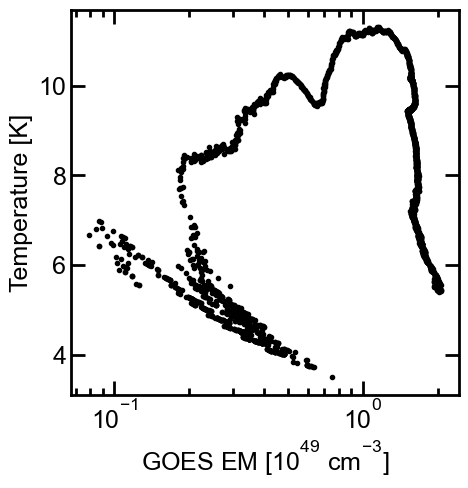

In [ ]:
fig= plt.figure(figsize=(5,5))
plt.subplots_adjust(wspace = 0, hspace = 0)
#plt.title("M1.0 Flare on 5-Nov-2010")
ax = fig.add_subplot(1, 1, 1)
ax.plot(em*1e-49,tmk,'.',color='black',lw=1)
ax.set_xlabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax.set_ylabel("Temperature [K]")
ax.set_xscale("log")
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
plt.show()

## Background Subtraction

In [ ]:
fl_hek_start = fl_info['event_starttime']
fl_hek_end = fl_info['event_endtime']
fl_class = fl_info['fl_goescls']

flare_time=a.Time(Time(fl_hek_start, scale='utc').iso, Time(fl_hek_end,scale='utc').iso)
bcktrunc_18=df_long.truncate(flare_time.start.iso,flare_time.end.iso)
old_peak = bcktrunc_18.idxmax()

# Background Time Calculation Function
bck_startt, bck_endt, smooth_bck, bck_tr_ts, bck_tr_vars, bck_flag = onsets.background(df_short, df_long, start_time = Time(fl_hek_start), peak_time = old_peak)
srch_time = a.Time(Time(bck_startt, scale='utc').iso, Time(bck_endt,scale='utc').iso)
trunc_054 = df_short.truncate(srch_time.start.iso,srch_time.end.iso)
trunc_18 = df_long.truncate(srch_time.start.iso,srch_time.end.iso)
bck_t = trunc_054.index
bck_short = np.mean(trunc_054)
bck_long = np.mean(trunc_18)
bck_short_std = np.std(trunc_054)
bck_long_std = np.std(trunc_18)

# Background Subtracting the Data
short_backsub = df_short - bck_short
long_backsub = df_long - bck_long

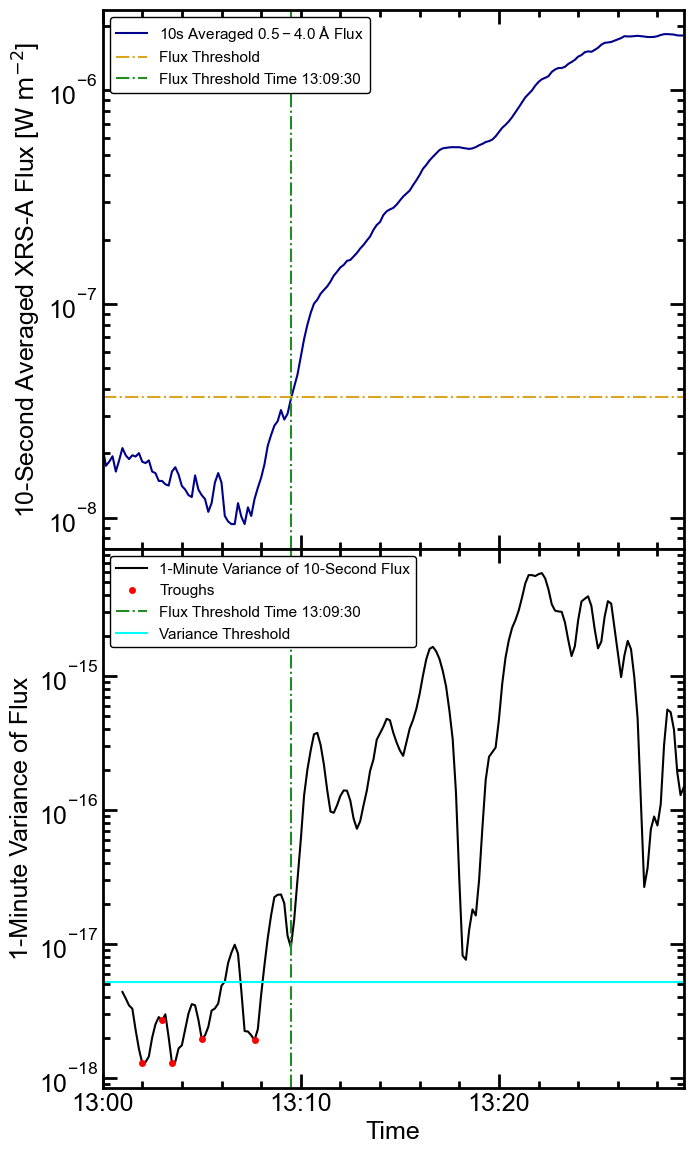

In [ ]:
flux_thresh = 2*smooth_bck.loc[smooth_bck['Variance'].idxmin(), 'Flux']
below_threshold = smooth_bck['Flux'] < flux_thresh
first_below_threshold = below_threshold.idxmax()
time_at_threshold = smooth_bck.index[below_threshold].max()

# Plotting
fig= plt.figure(figsize=(7.5,14))
plt.subplots_adjust(wspace = 0, hspace = 0)
#plt.title("M1.0 Flare on 5-Nov-2010")
ax = fig.add_subplot(2,1,1)
ax.plot(smooth_bck.index, smooth_bck['Flux'], color = 'darkblue', label = "10s Averaged $0.5-4.0\;\AA$ Flux")
ax.axhline(flux_thresh, ls = '-.', color = 'goldenrod', label = "Flux Threshold")
ax.axvline(time_at_threshold, ls = '-.', color = "forestgreen",label = f"Flux Threshold Time 13:09:30")
ax.set_ylabel("10-Second Averaged XRS-A Flux [$\mathrm{W\;m^{-2}}$]")
ax.set_yscale("log")
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax.set_xlim([min(smooth_bck.index), max(smooth_bck.index)])
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax.legend(fancybox = True, loc = "upper left", fontsize = 11, framealpha = 1, edgecolor = 'black')
ax.xaxis.set_ticklabels([])

ax_bck = fig.add_subplot(2, 1, 2)
ax_bck.plot(smooth_bck.index, smooth_bck['Variance'], color = 'black', label = '1-Minute Variance of 10-Second Flux')
ax_bck.plot(bck_tr_ts, bck_tr_vars, 'o', color = 'red', label = 'Troughs', markersize = 4)
ax_bck.axvline(time_at_threshold, ls = '-.', color = "forestgreen",label = "Flux Threshold Time 13:09:30")
ax_bck.axhline(np.nanmin(smooth_bck['Variance'].values)*4, color = "cyan", label = "Variance Threshold")
ax_bck.axvspan(xmin = smooth_bck.index[0], xmax = time_at_threshold, ymax = np.nanmin(smooth_bck['Variance'].values)*4)
ax_bck.set_ylabel("1-Minute Variance of Flux")
ax_bck.set_xlabel("Time")
ax_bck.set_yscale("log")
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax_bck.xaxis.set_major_locator(majorx)
ax_bck.xaxis.set_minor_locator(minorx)
ax_bck.xaxis.set_major_formatter(myFmt)
ax_bck.set_xlim([min(smooth_bck.index), max(smooth_bck.index)])
ax_bck.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax_bck.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax_bck.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax_bck.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax_bck.legend(fancybox = True, loc = "upper left", fontsize = 11, framealpha = 1, edgecolor = 'black')

plt.savefig("Presentation_Graphs/Background_Calc.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
flare_long = long_backsub.truncate(flare_time.start.iso,flare_time.end.iso)
true_peak = flare_long.idxmax()
print(true_peak)

2010-11-05 13:29:20.511000


In [ ]:
gtstart=Time("2010-11-05 13:00:00")
gtend=Time("2010-11-05 13:40:00")
trunc_range=a.Time(gtstart.iso,gtend.iso)
long_backsub=long_backsub.truncate(trunc_range.start.iso,trunc_range.end.iso)
short_backsub=short_backsub.truncate(trunc_range.start.iso,trunc_range.end.iso)
df_long=df_long.truncate(trunc_range.start.iso,trunc_range.end.iso)
df_short=df_short.truncate(trunc_range.start.iso,trunc_range.end.iso)

tmk, em = gtem.get_tem(df_long.values, df_short.values)

In [ ]:
print(bck_startt, bck_endt)

2010-11-05 13:06:40 2010-11-05 13:07:40


## TEM backsubbed


Mean T during onset: 10.38 MK
Mean EM during onset: 7.40e+48 cm^-3


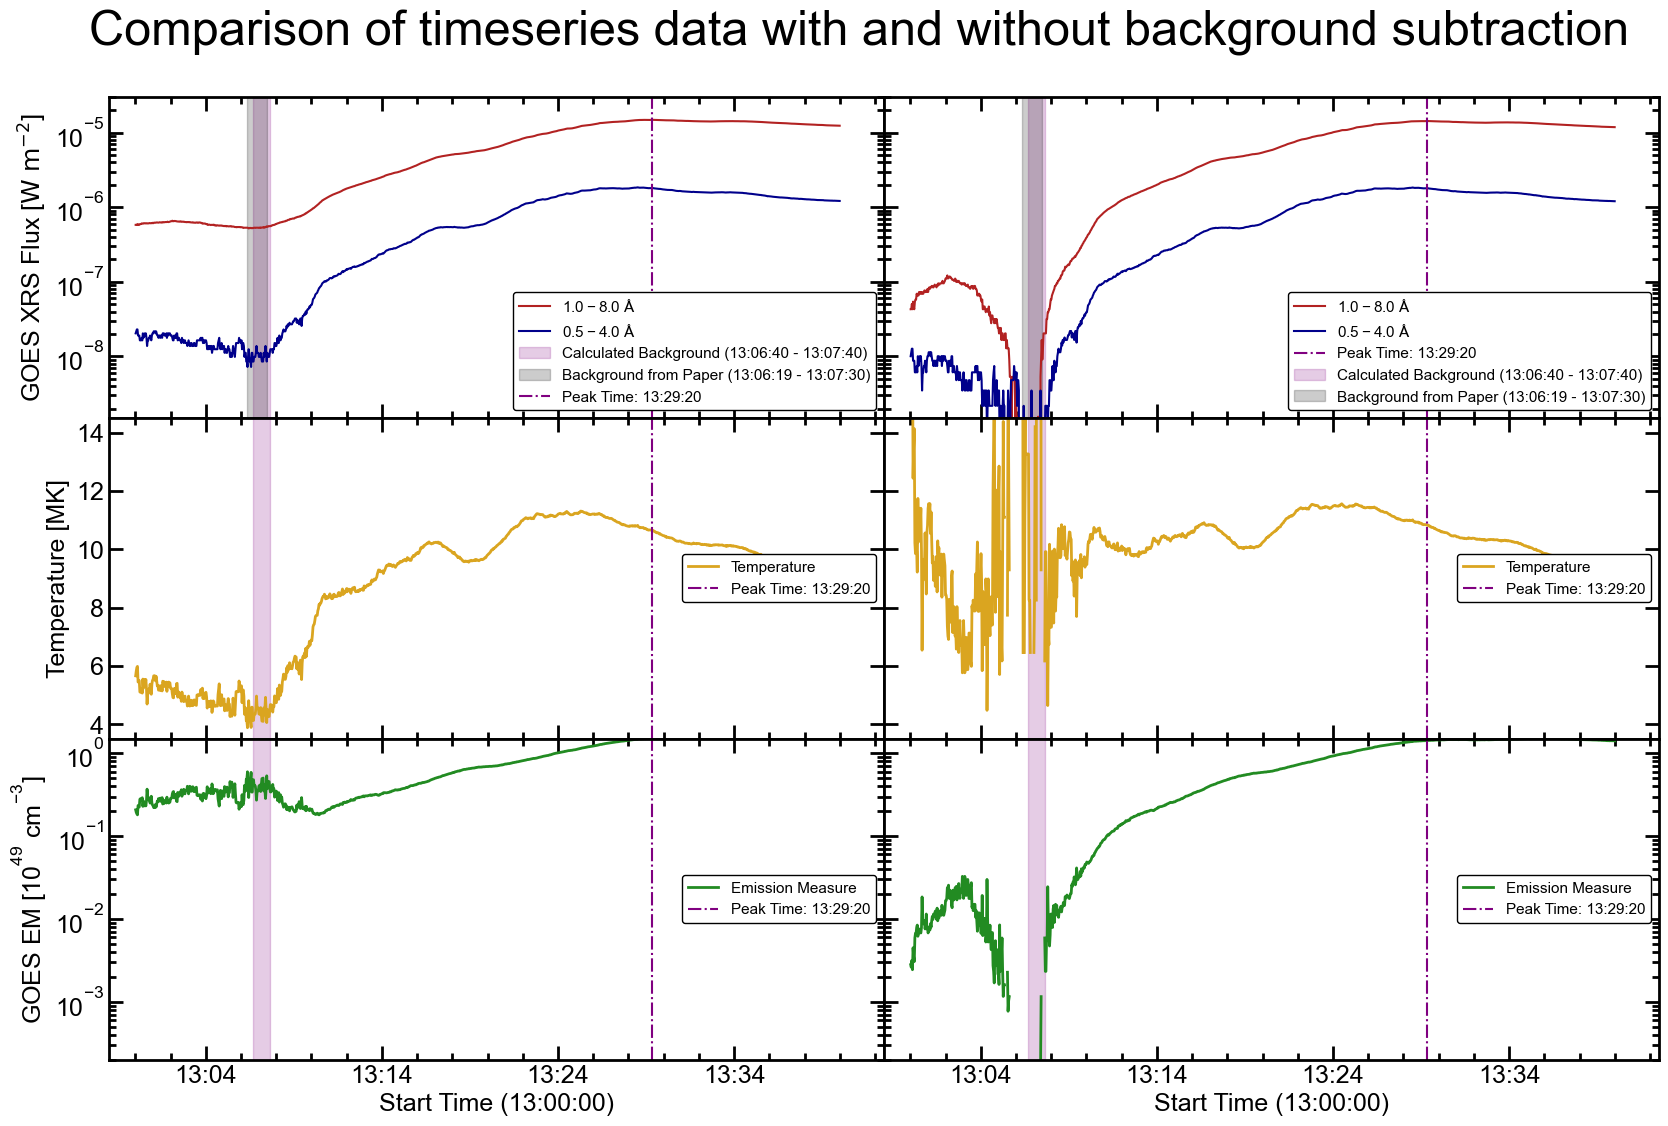

In [ ]:
# Fetching Temperature and Emission Measures
tmk_bck, em_bck = gtem.get_tem(long_backsub.values, short_backsub.values)

#calculating mean T, EM for backsubbed new data.
tmk_mnho_b=np.nanmean(tmk_bck)
em_mnho_b=np.nanmean(em_bck)
print("")
print('Mean T during onset: {0:.2f} MK'.format(tmk_mnho_b))
print('Mean EM during onset: {0:.2e} cm^-3'.format(em_mnho_b))

# Plotting
fig= plt.figure(figsize=(20,12.5))
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.tight_layout()
fig.suptitle('Comparison of timeseries data with and without background subtraction', y = 0.95, fontsize=35)

ax = fig.add_subplot(3,2,1)
ax.plot(df_long.index, df_long, color = 'firebrick',  label = r"$1.0-8.0\;\AA$")
ax.plot(df_short.index, df_short, color = 'darkblue', label = r"$0.5-4.0\;\AA$")
ax.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2, label  = "Calculated Background (13:06:40 - 13:07:40)")
ax.axvspan(Time("2010-11-05 13:06:19").datetime, Time("2010-11-05 13:07:30").datetime, color = 'black', alpha = 0.2, label = "Background from Paper (13:06:19 - 13:07:30)")
ax.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
# # ax.axvspan(parse_time(fl_info["event_starttime"]).datetime, parse_time(fl_info["event_endtime"]).datetime,color='black',alpha=0.2)
# ax.axvline(parse_time(fl_info["event_starttime"]).datetime,ls='-.', color = 'green', label = 'NOAA Start Time: 13:05')
# ax.axvline(parse_time(fl_info["event_endtime"]).datetime,ls='-.', color = 'green',label = 'NOAA End Time: 14:10')
ax.set_ylabel("GOES XRS Flux [$\mathrm{W\;m^{-2}}$]")
ax.set_yscale("log")
ax.set_ylim([1.5e-9, 3e-5])
ax.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax.xaxis.set_ticklabels([])
ax.legend(fancybox = True, loc = "lower right", fontsize = 11, framealpha = 1, edgecolor = 'black')


ax1 = fig.add_subplot(3, 2, 3)
#ax1.set_title("GOES-15 Temperature Responses")
ax1.plot(df_long.index,tmk,marker=None,color='goldenrod',lw=2,label="Temperature")
ax1.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
ax1.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax1.set_ylabel("Temperature [MK]")
ax1.set_ylim([3.5,14.5])
ax1.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
ax1.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax1.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax1.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax1.xaxis.set_ticklabels([])
ax1.legend(fancybox = True, loc = "center right", fontsize = 11, framealpha = 1, edgecolor = 'black')


#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax2 = fig.add_subplot(3, 2, 5)
ax2.plot(df_long.index,em*1e-49,marker=None,color='forestgreen',lw=2, label = "Emission Measure")
ax2.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
ax2.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax2.set_xlabel("Start Time (13:00:00)")
ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_yscale("log")
ax2.set_ylim([2e-4, 1.5e0])
ax2.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
ax2.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax2.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax2.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax2.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax2.legend(fancybox = True, loc = "center right", fontsize = 11, framealpha = 1, edgecolor = 'black')


#plt.title("M1.0 Flare on 5-Nov-2010")
ax4 = fig.add_subplot(3,2,2)
ax4.plot(long_backsub.index, long_backsub, color = 'firebrick',  label = r"$1.0-8.0\;\AA$")
ax4.plot(short_backsub.index, short_backsub, color = 'darkblue', label = r"$0.5-4.0\;\AA$")
ax4.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
ax4.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2, label  = "Calculated Background (13:06:40 - 13:07:40)")
ax4.axvspan(Time("2010-11-05 13:06:19").datetime, Time("2010-11-05 13:07:30").datetime, color = 'black', alpha = 0.2, label = "Background from Paper (13:06:19 - 13:07:30)")
ax4.set_yscale("log")
ax4.set_ylim([1.5e-9, 3e-5])
ax4.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax4.xaxis.set_major_locator(majorx)
ax4.xaxis.set_minor_locator(minorx)
ax4.xaxis.set_major_formatter(myFmt)
ax4.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax4.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax4.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax4.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax4.xaxis.set_ticklabels([])
ax4.yaxis.set_ticklabels([])
ax4.legend(fancybox = True, loc = "center right", fontsize = 11, framealpha = 1, edgecolor = 'black')


ax5 = fig.add_subplot(3, 2, 4)
#ax1.set_title("GOES-15 Temperature Responses")
ax5.plot(long_backsub.index,tmk_bck,marker=None,color='goldenrod',lw=2,label="Temperature")
ax5.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
ax5.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
#ax5.set_ylabel("Temperature [MK]")
ax5.set_ylim([3.5,14.5])
ax5.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax5.xaxis.set_major_locator(majorx)
ax5.xaxis.set_minor_locator(minorx)
ax5.xaxis.set_major_formatter(myFmt)
ax5.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax5.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax5.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax5.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax5.xaxis.set_ticklabels([])
ax5.yaxis.set_ticklabels([])
ax5.legend(fancybox = True, loc = "center right", fontsize = 11, framealpha = 1, edgecolor = 'black')


#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax6 = fig.add_subplot(3, 2, 6)
ax6.plot(long_backsub.index, em_bck*1e-49,marker=None,color='forestgreen',lw=2, label = "Emission Measure")
ax6.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
ax6.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax6.set_xlabel("Start Time (13:00:00)")
#ax6.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax6.set_yscale("log")
ax6.set_ylim([2e-4, 1.5e0])
ax6.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax6.xaxis.set_major_locator(majorx)
ax6.xaxis.set_minor_locator(minorx)
ax6.xaxis.set_major_formatter(myFmt)
ax6.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax6.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax6.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax6.tick_params(which='minor', size=5, width=2, direction='in', right='on')
#ax6.xaxis.set_ticklabels(["2010-11-05 13:00:00", "2010-11-05 13:15:00"])
ax6.yaxis.set_ticklabels([])
ax6.legend(fancybox = True, loc = "center right", fontsize = 11, framealpha = 1, edgecolor = 'black')

# ax_r1 = fig.add_subplot(4, 2, 3)
# ax_r1.plot(long_backsub.index, df_long/df_short, marker=None,color='forestgreen',lw=2, label = "Emission Measure")
# ax_r1.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
# ax_r1.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
# ax_r1.set_xlabel("Start Time (12:45:00)")
# #ax6.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
# ax_r1.set_yscale("log")
# ax_r1.set_ylim([3e0, 1e2])
# ax_r1.set_xlim([parse_time("2010-11-05 12:55:00").datetime, parse_time("2010-11-05 14:30:00").datetime])
# myFmt = matplotlib.dates.DateFormatter('%H:%M')
# majorx= matplotlib.dates.MinuteLocator(interval=30)
# minorx= matplotlib.dates.MinuteLocator(interval=5)
# ax_r1.xaxis.set_major_locator(majorx)
# ax_r1.xaxis.set_minor_locator(minorx)
# ax_r1.xaxis.set_major_formatter(myFmt)
# ax_r1.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
# ax_r1.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
# ax_r1.tick_params(which='major', size=10, width=2, direction='in', right='on')
# ax_r1.tick_params(which='minor', size=5, width=2, direction='in', right='on')
# #ax_r1.yaxis.set_ticklabels([])

# ax_r2 = fig.add_subplot(4, 2, 4)
# ax_r2.plot(long_backsub.index, long_backsub/short_backsub, marker=None,color='forestgreen',lw=2, label = "Emission Measure")
# ax_r2.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
# ax_r2.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
# ax_r2.set_xlabel("Start Time (12:45:00)")
# ax_r2.set_yscale("log")
# ax_r2.set_ylim([3e0, 1e2])
# ax_r2.set_xlim([parse_time("2010-11-05 12:55:00").datetime, parse_time("2010-11-05 14:30:00").datetime])
# myFmt = matplotlib.dates.DateFormatter('%H:%M')
# majorx= matplotlib.dates.MinuteLocator(interval=30)
# minorx= matplotlib.dates.MinuteLocator(interval=5)
# ax_r2.xaxis.set_major_locator(majorx)
# ax_r2.xaxis.set_minor_locator(minorx)
# ax_r2.xaxis.set_major_formatter(myFmt)
# ax_r2.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
# ax_r2.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
# ax_r2.tick_params(which='major', size=10, width=2, direction='in', right='on')
# ax_r2.tick_params(which='minor', size=5, width=2, direction='in', right='on')
# ax_r2.yaxis.set_ticklabels([])
# ax_r2.yaxis.set_ticklabels([])


plt.savefig("Presentation_Graphs/TEM_compare.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

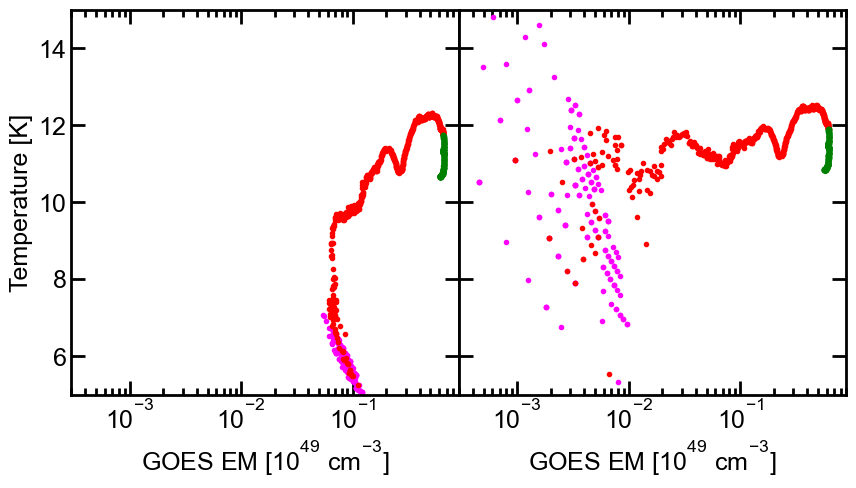

In [ ]:


trunc_054_tem_pre = short_backsub.truncate(np.nanmin(short_backsub.index), bck_endt)
trunc_18_tem_pre = long_backsub.truncate(np.nanmin(long_backsub.index), bck_endt)
trunc_054_tem_pre_nosub = df_short.truncate(np.nanmin(short_backsub.index), bck_endt)
trunc_18_tem_pre_nosub = df_long.truncate(np.nanmin(long_backsub.index), bck_endt)

trunc_054_tem_imp = short_backsub.truncate(bck_endt, Time(true_peak).datetime)
trunc_18_tem_imp = long_backsub.truncate(bck_endt, Time(true_peak).datetime)
trunc_054_tem_imp_nosub = df_short.truncate(bck_endt, Time(true_peak).datetime)
trunc_18_tem_imp_nosub = df_long.truncate(bck_endt, Time(true_peak).datetime)

trunc_054_tem_end = short_backsub.truncate(Time(true_peak).datetime, Time(fl_info['event_endtime']).datetime)
trunc_18_tem_end = long_backsub.truncate(Time(true_peak).datetime, Time(fl_info['event_endtime']).datetime)
trunc_054_tem_end_nosub = df_short.truncate(Time(true_peak).datetime, Time(fl_info['event_endtime']).datetime)
trunc_18_tem_end_nosub = df_long.truncate(Time(true_peak).datetime, Time(fl_info['event_endtime']).datetime)

tmk_pre, em_pre = gtem.get_tem(trunc_18_tem_pre, trunc_054_tem_pre) 
tmk_imp, em_imp = gtem.get_tem(trunc_18_tem_imp, trunc_054_tem_imp) 
tmk_end, em_end = gtem.get_tem(trunc_18_tem_end, trunc_054_tem_end)  
tmk_pre_ns, em_pre_ns = gtem.get_tem(trunc_18_tem_pre_nosub, trunc_054_tem_pre_nosub) 
tmk_imp_ns, em_imp_ns = gtem.get_tem(trunc_18_tem_imp_nosub, trunc_054_tem_imp_nosub) 
tmk_end_ns, em_end_ns = gtem.get_tem(trunc_18_tem_end_nosub, trunc_054_tem_end_nosub)  

fig= plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace = 0, hspace = 0)
#plt.title("M1.0 Flare on 5-Nov-2010")
ax = fig.add_subplot(1, 2, 1)
ax.plot(em_pre_ns*1e-49,tmk_pre_ns,'.',color='magenta',lw=1)
ax.plot(em_imp_ns*1e-49,tmk_imp_ns,'.',color='red',lw=1)
ax.plot(em_end_ns*1e-49,tmk_end_ns,'.',color='green',lw=1)
ax.set_xlabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax.set_ylabel("Temperature [K]")
ax.set_ylim([5,15])
ax.set_xlim([3e-4,9e-1])
ax.set_xscale("log")
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')

ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(em_pre*1e-49,tmk_pre,'.',color='magenta',lw=1)
ax1.plot(em_imp*1e-49,tmk_imp,'.',color='red',lw=1)
ax1.plot(em_end*1e-49,tmk_end,'.',color='green',lw=1)
ax1.set_xlabel("GOES EM [$10^{49}\;cm^{-3}$]")
#ax1.set_ylabel("Temperature [K]")
ax1.set_ylim([5,15])
ax1.set_xlim([3e-4,9e-1])
ax1.set_xscale("log")
ax1.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax1.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax1.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax1.yaxis.set_ticklabels([])

plt.show()


## Plotting Onset Intervals

In [ ]:
# Calculating the first acceptable point of onset using backsubbed long channel
srch_start = Time(bck_endt) - TimeDelta(60, format = 'sec')
trange_search = a.Time(srch_start, true_peak)
g_long_srch = long_backsub.truncate(trange_search.start.iso,trange_search.end.iso)
g_short_srch = short_backsub.truncate(trange_search.start.iso,trange_search.end.iso)

indexes = g_long_srch[(g_long_srch >= 4*bck_long_std) & (g_short_srch >= 4*bck_short_std)].index
if len(indexes) == 0:
    raise ValueError
else:
    first_index = indexes[0]

# Onset and TEM Calculations of different onset definitions 
# Lots of inefficient calculating going on here, but it makes it clearer to track the variables

if first_index > bck_endt:
    onset_start = first_index
else:
    onset_start = bck_endt                                                                               

# Calcualting the time length of the each fractional onset interval, as well as the end time of that interval
endt_eighth = onsets.scaled_onset(onset_start, true_peak, 8)
timedelta_eighth = pd.to_timedelta(endt_eighth - onset_start).total_seconds()
endt_sixth = onsets.scaled_onset(onset_start, true_peak, 6)
timedelta_sixth = pd.to_timedelta(endt_sixth - onset_start).total_seconds()
endt_quarter = onsets.scaled_onset(onset_start, true_peak, 4)
timedelta_quarter = pd.to_timedelta(endt_quarter - onset_start).total_seconds()
endt_third = onsets.scaled_onset(onset_start, true_peak, 3)
timedelta_third = pd.to_timedelta(endt_third - onset_start).total_seconds()
endt_half = onsets.scaled_onset(onset_start, true_peak, 2)
timedelta_half = pd.to_timedelta(endt_half - onset_start).total_seconds()
endt_twothirds = onsets.scaled_onset(onset_start, true_peak, 3/2)
timedelta_twothirds = pd.to_timedelta(endt_twothirds - onset_start).total_seconds()
endt_threequart = onsets.scaled_onset(onset_start, true_peak, 4/3)
timedelta_threequart= pd.to_timedelta(endt_threequart - onset_start).total_seconds()


trunc_054_tem_ons = short_backsub.truncate(onset_start, endt_eighth)
trunc_18_tem_ons = long_backsub.truncate(onset_start, endt_eighth)
tmk_ons_avg, em_ons_avg = gtem.get_tem(np.nanmean(trunc_18_tem_ons), np.nanmean(trunc_054_tem_ons)) 
tmk_ons, em_ons = gtem.get_tem(trunc_18_tem_ons, trunc_054_tem_ons) 

trunc_18_tem_ons_ns = df_long.truncate(onset_start, endt_eighth)
trunc_054_tem_ons_ns = df_short.truncate(onset_start, endt_eighth)
tmk_ons_ns_avg, em_ons_ns_avg = gtem.get_tem(np.nanmean(trunc_18_tem_ons_ns), np.nanmean(trunc_054_tem_ons_ns))
tmk_ons_ns, em_ons_ns = gtem.get_tem(trunc_18_tem_ons_ns, trunc_054_tem_ons_ns) 

In [ ]:
print(bck_startt, bck_endt)
print(onset_start)

2010-11-05 13:06:40 2010-11-05 13:07:40
2010-11-05 13:08:04.625000


## Plotting the different fractional onsets

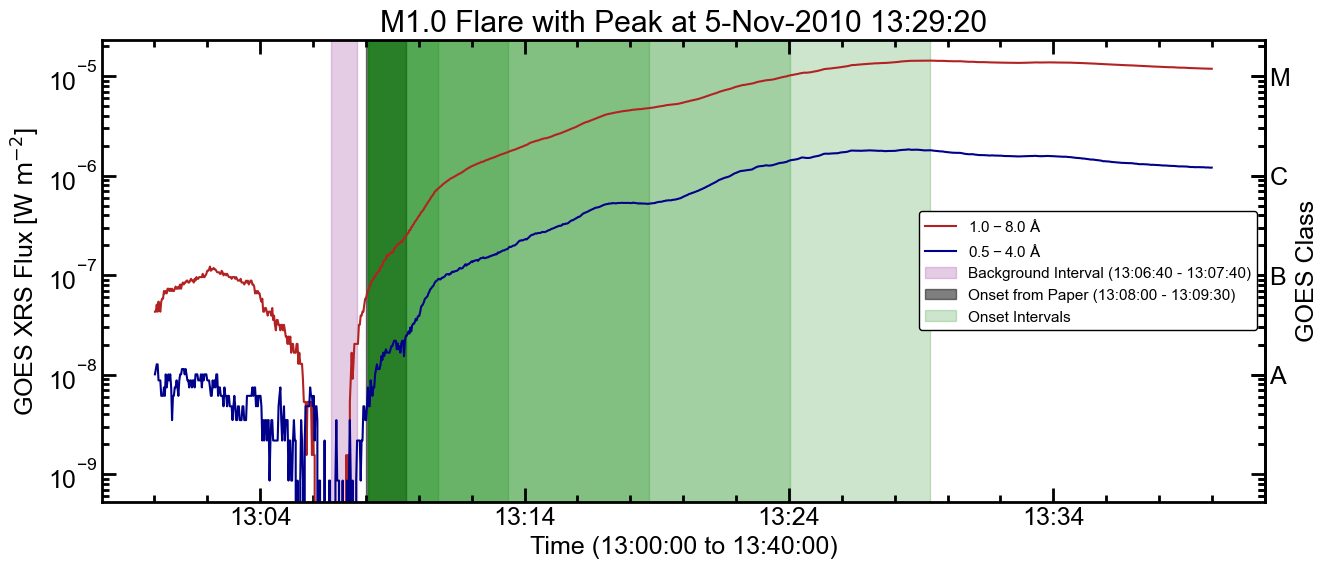

In [ ]:
# Plotting
fig,ax = plt.subplots(figsize=(15, 6))
plt.title("M1.0 Flare with Peak at 5-Nov-2010 13:29:20")
plt.plot(long_backsub.index, long_backsub, color = 'firebrick',  label = r"$1.0-8.0\;\AA$")
plt.plot(short_backsub.index, short_backsub, color = 'darkblue', label = r"$0.5-4.0\;\AA$")


# ax.axvline(parse_time(fl_info["event_peaktime"]).datetime,ls='-.', color = 'purple',label = "NOAA Peak Time: 13:29")
# # ax.axvspan(parse_time(fl_info["event_starttime"]).datetime, parse_time(fl_info["event_endtime"]).datetime,color='black',alpha=0.2)
# ax.axvline(parse_time(fl_info["event_starttime"]).datetime,ls='-.', color = 'green', label = 'NOAA Start Time: 13:05')
# ax.axvline(parse_time(fl_info["event_endtime"]).datetime,ls='-.', color = 'green',label = 'NOAA End Time: 14:10')

ax.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2, label = "Background Interval (13:06:40 - 13:07:40)")
ax.axvspan(Time("2010-11-05 13:08:00").datetime, Time("2010-11-05 13:09:30").datetime, color = 'black', alpha = 0.5, label = "Onset from Paper (13:08:00 - 13:09:30)")
ax.axvspan(onset_start, endt_eighth, color = 'green', alpha = 0.2, label = "Onset Intervals")
ax.axvspan(onset_start, endt_quarter, color = 'green', alpha = 0.2)
ax.axvspan(onset_start, endt_half, color = 'green', alpha = 0.2)
ax.axvspan(onset_start, endt_threequart, color = 'green', alpha = 0.2)
ax.axvspan(onset_start, true_peak, color = 'green', alpha = 0.2)

ax.set_ylabel("GOES XRS Flux [$\mathrm{W\;m^{-2}}$]")
ax.set_xlabel("Time (13:00:00 to 13:40:00)")
ax.set_yscale("log")

myFmt = matplotlib.dates.DateFormatter('%H:%M')
# majorx= matplotlib.dates.HourLocator(interval=0.5)
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')

class_fluxes = {'A':1e-8,'B': 1e-7, 'C': 1e-6, 'M': 1e-5, 'X': 1e-4}

# Set the tick locations and labels on the secondary y-axis
goes_ax = ax.secondary_yaxis('right')
goes_ax.set_yticks([class_fluxes['A'],class_fluxes['B'], class_fluxes['C'], class_fluxes['M'], class_fluxes['X']])
goes_ax.set_yticklabels(['A','B', 'C', 'M', 'X'], fontsize=18)
goes_ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
goes_ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
goes_ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
goes_ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
goes_ax.set_ylabel('GOES Class', fontsize=18)

ax.legend(fancybox = True, loc = "center right", fontsize = 11, framealpha = 1, edgecolor = 'black')
plt.savefig("Presentation_Graphs/Onset_fracs.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

## Plotting the 1/8th TEM

Mean 1-8 Flux during onset: 2.90e-07 
Mean 1-8 Flux during onset no backsub: 8.28e-07 

Mean 0.5-4 Flux during onset: 3.18e-08 
Mean 0.5-4 Flux during onset no backsub: 4.21e-08 

Mean T during onset: 11.21 MK
Mean T during onset no backsub: 7.89 MK

Mean EM during onset: 1.34e+47 cm^-3
Mean EM during onset: 6.32e+47 cm^-3


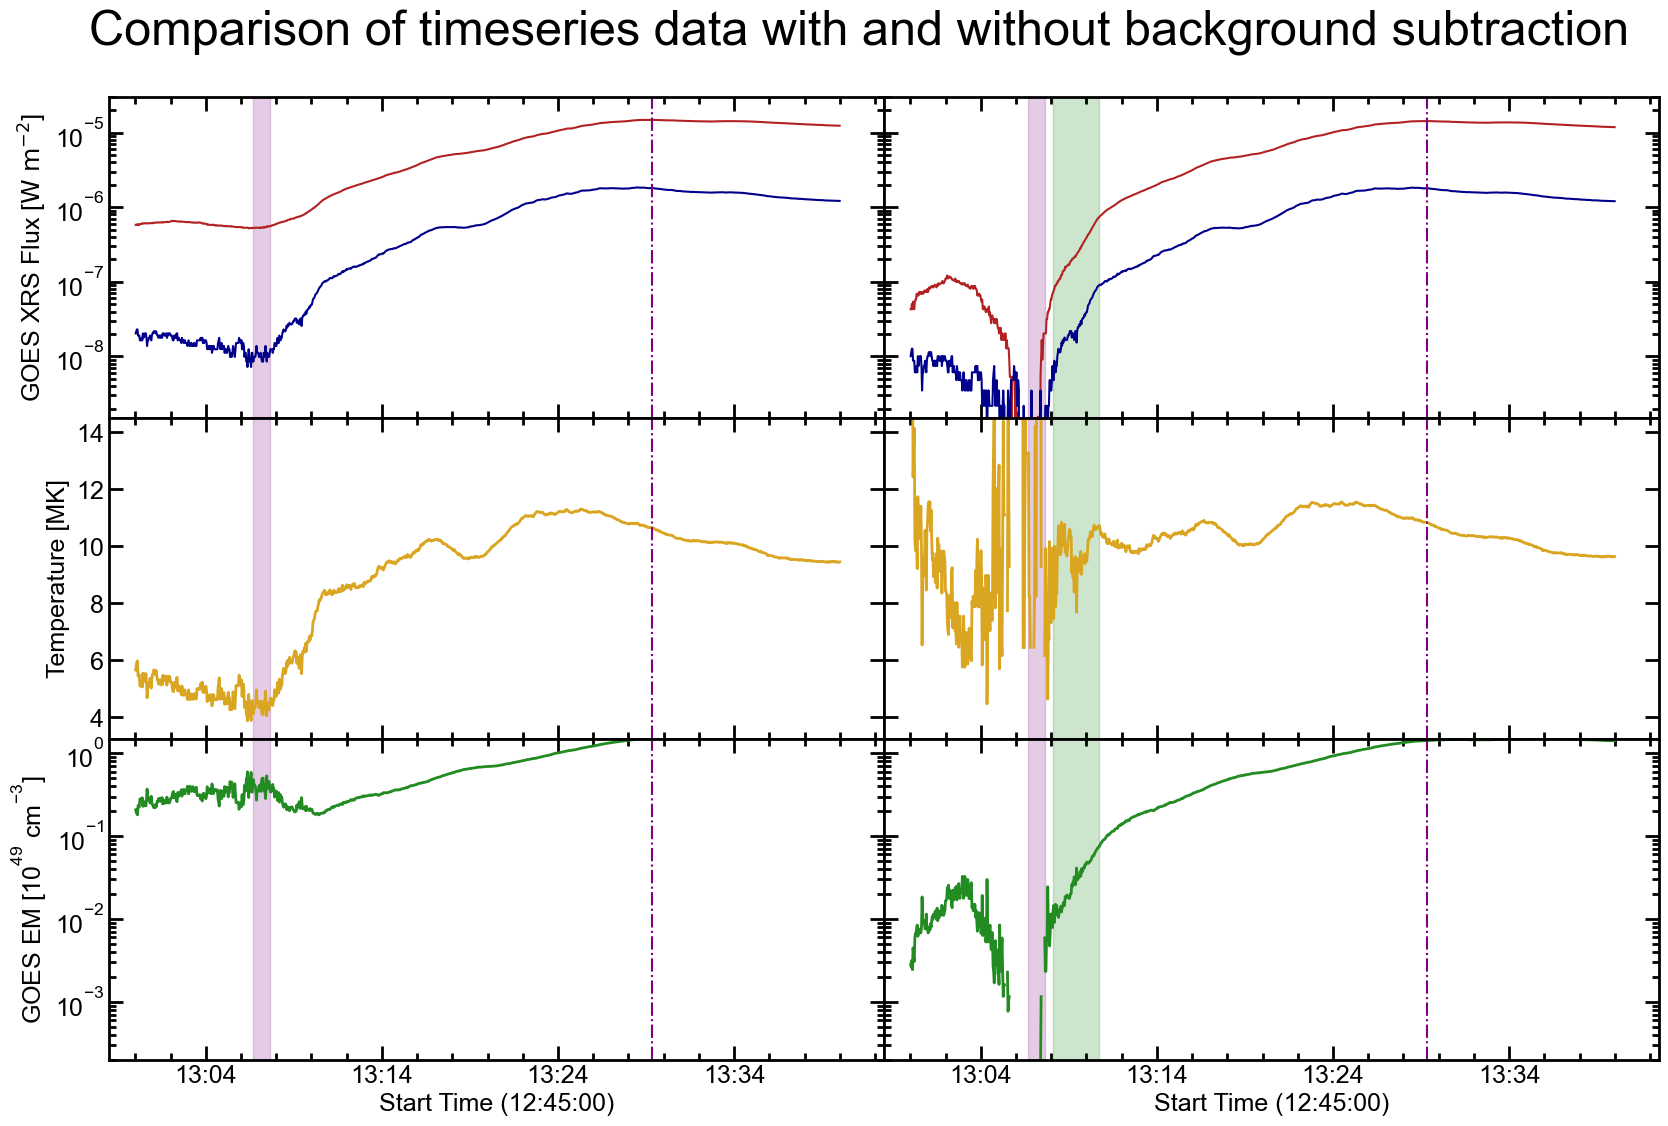

In [ ]:
#calculating mean T, EM for backsubbed new data.
print('Mean 1-8 Flux during onset: {0:.2e} '.format(np.mean(trunc_18_tem_ons)))
print('Mean 1-8 Flux during onset no backsub: {0:.2e} '.format(np.nanmean(trunc_18_tem_ons_ns)))
print("")
print('Mean 0.5-4 Flux during onset: {0:.2e} '.format(np.nanmean(trunc_054_tem_ons)))
print('Mean 0.5-4 Flux during onset no backsub: {0:.2e} '.format(np.nanmean(trunc_054_tem_ons_ns)))
print("")
print('Mean T during onset: {0:.2f} MK'.format(tmk_ons_avg))
print('Mean T during onset no backsub: {0:.2f} MK'.format(tmk_ons_ns_avg))
print("")
print('Mean EM during onset: {0:.2e} cm^-3'.format(em_ons_avg))
print('Mean EM during onset: {0:.2e} cm^-3'.format(em_ons_ns_avg))

# Plotting
fig= plt.figure(figsize=(20,12.5))
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.tight_layout()
fig.suptitle('Comparison of timeseries data with and without background subtraction', y = 0.95, fontsize=35)

ax = fig.add_subplot(3,2,1)
ax.plot(df_long.index, df_long, color = 'firebrick',  label = r"$1.0-8.0\;\AA$")
ax.plot(df_short.index, df_short, color = 'darkblue', label = r"$0.5-4.0\;\AA$")
ax.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
# # ax.axvspan(parse_time(fl_info["event_starttime"]).datetime, parse_time(fl_info["event_endtime"]).datetime,color='black',alpha=0.2)
# ax.axvline(parse_time(fl_info["event_starttime"]).datetime,ls='-.', color = 'green', label = 'NOAA Start Time: 13:05')
# ax.axvline(parse_time(fl_info["event_endtime"]).datetime,ls='-.', color = 'green',label = 'NOAA End Time: 14:10')
ax.set_ylabel("GOES XRS Flux [$\mathrm{W\;m^{-2}}$]")
ax.set_yscale("log")
ax.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
ax.set_ylim([1.5e-9, 3e-5])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax.xaxis.set_ticklabels([])

ax1 = fig.add_subplot(3, 2, 3)
#ax1.set_title("GOES-15 Temperature Responses")
ax1.plot(df_long.index,tmk,marker=None,color='goldenrod',lw=2,label="Temperature")
ax1.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
ax1.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax1.set_ylabel("Temperature [MK]")
ax1.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
ax1.set_ylim([3.25,14.5])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
ax1.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax1.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax1.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax1.xaxis.set_ticklabels([])

#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax2 = fig.add_subplot(3, 2, 5)
ax2.plot(df_long.index,em*1e-49,marker=None,color='forestgreen',lw=2, label = "Emission Measure")
ax2.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
ax2.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
# ax2.axvspan(onset_start, endt_eighth, color = 'green', alpha = 0.2)
# ax2.axvspan(onset_start, endt_sixth, color = 'green', alpha = 0.2)
# ax2.axvspan(onset_start, endt_third, color = 'green', alpha = 0.2)
ax2.set_xlabel("Start Time (12:45:00)")
ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_yscale("log")
ax2.set_ylim([2e-4, 1.5e0])
ax2.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
ax2.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax2.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax2.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax2.tick_params(which='minor', size=5, width=2, direction='in', right='on')

#plt.title("M1.0 Flare on 5-Nov-2010")
ax4 = fig.add_subplot(3,2,2)
ax4.plot(long_backsub.index, long_backsub, color = 'firebrick',  label = r"$1.0-8.0\;\AA$")
ax4.plot(short_backsub.index, short_backsub, color = 'darkblue', label = r"$0.5-4.0\;\AA$")
ax4.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
ax4.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax4.axvspan(onset_start, endt_eighth, color = 'green', alpha = 0.2)
# ax4.axvspan(onset_start, endt_sixth, color = 'green', alpha = 0.2)
# ax4.axvspan(onset_start, endt_third, color = 'green', alpha = 0.2)
ax4.set_yscale("log")
ax4.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
ax4.set_ylim([1.5e-9, 3e-5])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval = 10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax4.xaxis.set_major_locator(majorx)
ax4.xaxis.set_minor_locator(minorx)
ax4.xaxis.set_major_formatter(myFmt)
ax4.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax4.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax4.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax4.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax4.xaxis.set_ticklabels([])
ax4.yaxis.set_ticklabels([])

ax5 = fig.add_subplot(3, 2, 4)
ax5.plot(long_backsub.index,tmk_bck,marker=None,color='goldenrod',lw=2,label="Temperature")
ax5.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
ax5.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax5.axvspan(onset_start, endt_eighth, color = 'green', alpha = 0.2)
# ax5.axvspan(onset_start, endt_sixth, color = 'green', alpha = 0.2)
# ax5.axvspan(onset_start, endt_third, color = 'green', alpha = 0.2)
ax5.set_ylim([3.25,14.5])
ax5.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax5.xaxis.set_major_locator(majorx)
ax5.xaxis.set_minor_locator(minorx)
ax5.xaxis.set_major_formatter(myFmt)
ax5.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax5.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax5.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax5.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax5.xaxis.set_ticklabels([])
ax5.yaxis.set_ticklabels([])

#ax1.grid()
#plt.legend(fancybox = True,title='XRS{:.0f}'.format(sat))

ax6 = fig.add_subplot(3, 2, 6)
ax6.plot(long_backsub.index, em_bck*1e-49,marker=None,color='forestgreen',lw=2, label = "Emission Measure")
ax6.axvline(true_peak,ls='-.', color = 'purple',label = "Peak Time: 13:29:20")
ax6.axvspan(bck_startt, bck_endt, color = 'purple', alpha = 0.2)
ax6.axvspan(onset_start, endt_eighth, color = 'green', alpha = 0.2, label = "Onset EM: ")
# ax6.axvspan(onset_start, endt_sixth, color = 'green', alpha = 0.2)
# ax6.axvspan(onset_start, endt_third, color = 'green', alpha = 0.2)
ax6.set_xlabel("Start Time (12:45:00)")
#ax6.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax6.set_yscale("log")
ax6.set_ylim([2e-4, 1.5e0])
ax6.set_xlim([parse_time("2010-11-05 12:58:30").datetime, parse_time("2010-11-05 13:42:30").datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=2)
ax6.xaxis.set_major_locator(majorx)
ax6.xaxis.set_minor_locator(minorx)
ax6.xaxis.set_major_formatter(myFmt)
ax6.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax6.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax6.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax6.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax6.yaxis.set_ticklabels([])


plt.savefig("Presentation_Graphs/TEM_compare.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

# Finding 